In [1]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import metrics
from keras.optimizers import Adam

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [34]:
def norm_stats(dfs):
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    maximum = np.max(dfs)
    return (mu, sigma, maximum)

def z_score(col, stats):
    mu, s, maximum = stats
    df = pd.DataFrame()
    for c in col.columns:
        df[c] = (col[c]-mu[c])/s[c]
    return df

def z_score2(col, stats):
    mu, s, maximum = stats
    df = pd.DataFrame()
    for c in col.columns:
        df[c] = col[c]/maximum[c]
    return df

import keras.backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [40]:
Y = data['price'].values/1000
#columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
columns = ['sqft_living', 'sqft_lot', 'floors', 'waterfront', 'sqft_above', 'sqft_basement']
dfs = data[columns]
#X = dfs.values

stats = norm_stats(dfs)

X = np.array(z_score2(dfs, stats))

# See https://www.kaggle.com/ironfrown/deep-learning-house-price-prediction-keras
# For scaling

zipcodes = pd.get_dummies(data['zipcode']).values
condition = pd.get_dummies(data['condition']).values
grade = pd.get_dummies(data['grade']).values
bedrooms = pd.get_dummies(data['bedrooms']).values
bathrooms = pd.get_dummies(data['bathrooms']).values

X = np.concatenate((X,zipcodes),axis = 1)
X = np.concatenate((X,condition),axis = 1)
X = np.concatenate((X,grade),axis = 1)
X = np.concatenate((X,bedrooms),axis = 1)
X = np.concatenate((X,bathrooms),axis = 1)

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state=42)

In [41]:
#model = Sequential()
#model.add(Dense(50,input_dim = x_train.shape[1],kernel_initializer="normal",activation = 'relu'))
#model.add(Dense(20,kernel_initializer="normal",activation = 'relu'))
#model.add(Dropout(0.1))
#model.add(Dense(5,kernel_initializer="normal",activation = 'relu'))
#model.add(Dense(1,kernel_initializer="normal"))

In [42]:
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=(x_train.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(50, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(1))

In [43]:
#model.compile(loss='mse', optimizer='adam', metrics=['mae', rmse])
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=[metrics.mae, rmse])

history = model.fit(x_train,y_train,epochs=20, verbose=1, validation_data=(x_test, y_test))
print(model.evaluate(x_test,y_test))

Train on 16209 samples, validate on 5404 samples
Epoch 1/20
16209/16209 [==============================] - 3s 181us/step - loss: 136982.7054 - mean_absolute_error: 217.8199 - rmse: 217.8199 - val_loss: 50456.4911 - val_mean_absolute_error: 110.7633 - val_rmse: 110.7633
Epoch 2/20
16209/16209 [==============================] - 2s 101us/step - loss: 34683.7712 - mean_absolute_error: 99.3245 - rmse: 99.3245 - val_loss: 31318.7044 - val_mean_absolute_error: 90.7381 - val_rmse: 90.7381
Epoch 3/20
16209/16209 [==============================] - 2s 100us/step - loss: 25899.7282 - mean_absolute_error: 89.0125 - rmse: 89.0125 - val_loss: 24879.5004 - val_mean_absolute_error: 90.8019 - val_rmse: 90.8019
Epoch 4/20
16209/16209 [==============================] - 2s 101us/step - loss: 22213.3519 - mean_absolute_error: 84.9800 - rmse: 84.9800 - val_loss: 21859.7196 - val_mean_absolute_error: 81.5061 - val_rmse: 81.5061
Epoch 5/20
16209/16209 [==============================] - 2s 100us/step - loss: 20

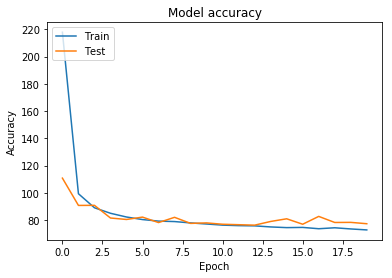

In [44]:
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [49]:
y_pred = model.predict(x_test)

In [52]:
len(x_test)

5404

ValueError: x and y must be the same size

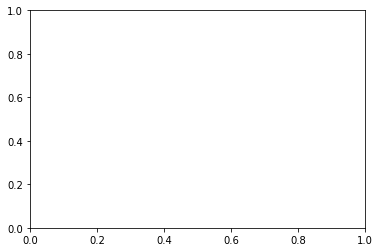

In [50]:
plt.scatter(x_test, y_pred, color="red", label="Price")
plt.title("Housing Prices in King County, WA")
plt.xlabel("True price")
plt.ylabel("Predicted price")
plt.legend()
plt.show()